# Demonstration of the Earthquake Catalogue Tools

The earthquake catalogue toolkit <b>OQ-EQCAT</b> contains tools for data mining earthquake databases for the ultimate aim of creating a magnitude homogeneous earthquake catalogue.

In this tutorial we will do the following:

1. Build an earthquake catalogue database using data from the International Seismological Centre (www.isc.ac.uk)

2. Apply various selection criteria

3. Explore different catalogue/agency regressions

4. Select several agencies and apply a homogenisation

# Building the database

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import eqcat.parsers.isf_catalogue_reader as icr
import eqcat.catalogue_query_tools as cqt

We are interested only in the events that the reporting networks believe to be natural tectonic events.

Using the descriptions reported in the contributing agencies we remove events with descriptions containing specific keywords indicating anthropogenic origin.

In [3]:
raw_file = "input_data/catalogues/catalogue_input_raw.txt"
rejection_keywords = ["mining", "geothermal", "explosion", "quarry", "reservoir", "rockburst"]
reader = icr.ISFReader(raw_file, rejection_keywords=rejection_keywords)
catalogue = reader.read_file("FRC", "ISC (France)")

We keep those events identified as anthropogenic in a separate database stored in the reader class.

Which events have been rejected and why.

In [4]:
for event in reader.rejected_catalogue.events:
    print event.id, event.description, event.comment

851798 Germany ROCKBURST

833565 United Kingdom CHEMICAL EXPLOSION OF ABOUT 500 TONS

757112 Germany ROCKBURST IN THE RUHR DISTRICT OF NORDRHEIN-WESTFALEN. 9 MINERS KILLED  IN THE MINE SACHSEN AT 1000M. UNDERGROUND. FELT STRONGLY AT
 HEESSEN, HAMM IN

745391 France ROCKBURST IN THE ROCHONVILLERS MINE. SLIGHT DAMAGE AT THE SURFACE. FELT SLIGHTLY IN HIGH-RISE FLATS IN THIONVILLE. (SEE GALLERY COLLAPSE OF
 1973 APRIL 20D. 12H.

738507 Germany ROCKBURST IN THE RUHR COAL DISTRICT OF NORDRHEIN-WESTFALEN. FELT IN THE REGION OF GELSENKIRCHEN, ESSEN, WATTENSCHEID AND WANNE-EICKEL, IO=V
 MM. RADIUS OF PE RCEPTIBILITY=5KM.

728117 Germany TO THE EAST OF BAD HERSFELD; SLIGHT DAMAGE WITH I=VII MCS IN THE EPICENT RAL REGION (AFTER BNS
 REPORT
 EVENT (MINING BLAST
FELT STRONGLY IN PARTS OF THE STATE OF HESSE AND THE RHINELAND.

567288 Corsica Less reliable solution.
Probable explosion.

567349 Corsica Less reliable solution.
Duration Magnitude Probable explosion.

538307 France Less reliable solution

Now we can build the database and store it to file - we only need to do this once!

In [5]:
# Build HDF5 database
CAT_DB_FILE = "output_data/catalogue_db.hdf5"
_ = catalogue.build_dataframe(CAT_DB_FILE)
print "Comment this section out after first use!"

Comment this section out after first use!


From now on we can simply load in the data from the database

In [6]:
CAT_DB_FILE = "output_data/catalogue_db.hdf5"
db1 = cqt.CatalogueDB(CAT_DB_FILE)

#### Origin Table

In [7]:
db1.origins

,eventID,originID,Agency,year,month,day,hour,minute,second,time_error,longitude,latitude,depth,depthSolution,semimajor90,semiminor90,error_strike,depth_error,prime
0,914182,1961813,GUTE,1911,11,16,21,25,48.000000,0.00,9.1000,48.299999,40.0,,0.0,0.0,0.0,0.00,0
1,912596,1959832,ISS,1920,9,7,5,55,40.000000,0.00,11.2000,43.799999,NaN,,0.0,0.0,0.0,0.00,0
2,912596,1959831,GUTE,1920,9,7,5,55,40.000000,0.00,10.0000,44.000000,35.0,,0.0,0.0,0.0,0.00,1
3,911442,1958532,ISS,1923,7,10,5,31,12.000000,0.00,-1.0000,42.799999,NaN,,0.0,0.0,0.0,0.00,0
4,911442,1958531,GUTE,1923,7,10,5,31,13.000000,0.00,-0.7500,42.500000,35.0,,0.0,0.0,0.0,0.00,1
5,906812,1952786,MOS,1931,6,7,0,25,13.000000,0.00,3.5000,54.500000,NaN,,0.0,0.0,0.0,0.00,0
6,906812,1952787,STR,1931,6,7,0,25,13.000000,0.00,2.0000,53.500000,NaN,,0.0,0.0,0.0,0.00,0
7,906812,1952788,KEW,1931,6,7,0,25,21.000000,0.00,1.2000,53.799999,NaN,,0.0,0.0,0.0,0.00,0
8,906812,1952785,GUTE,1931,6,7,0,25,13.000000,0.00,1.2500,54.000000,35.0,,0.0,0.0,0.0,0.00,1
9,904164,1948413,STR,1935,3,19,7,27,21.000000,0.00,6.5000,44.700001,NaN,,0.0,0.0,0.0,0.00,0


#### Magnitude Table

In [8]:
db1.magnitudes

,eventID,originID,magnitudeID,value,sigma,magType,magAgency
0,914182,1961813,1961813|PAS|6.20|MS,6.2,0.0,MS,PAS
1,912596,1959831,1959831|PAS|5.80|MS,5.8,0.0,MS,PAS
2,911442,1958531,1958531|PAS|5.60|MS,5.6,0.0,MS,PAS
3,906812,1952785,1952785|PAS|5.60|MS,5.6,0.0,MS,PAS
4,904164,1948412,1948412|PAS|5.60|MS,5.6,0.0,MS,PAS
5,904358,1948704,1948704|PAS|5.60|MS,5.6,0.0,MS,PAS
6,902529,1945859,1945859|PAS|5.60|MS,5.6,0.0,MS,PAS
7,902715,1946170,1946170|PAS|5.20|MS,5.2,0.0,MS,PAS
8,898227,1938993,1938993|PAS|6.00|MS,6.0,0.0,MS,PAS
9,898412,1939211,1939211|PAS|5.80|MS,5.8,0.0,MS,PAS


## Visualising the Catalogue

View the whole catalogue ...

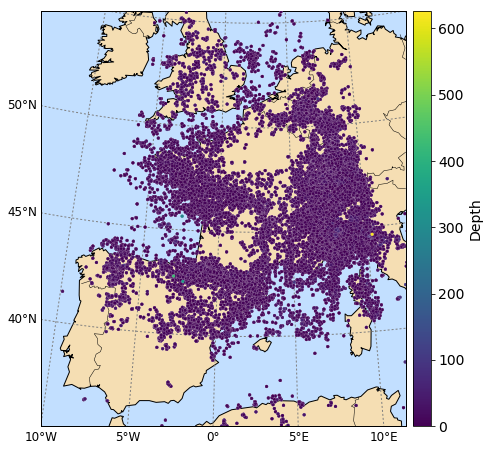

In [9]:
# Set up the configuration of the limits
map_config = {"llon": -10.0, "ulon": 15., "llat": 35.0, "ulat": 55.0, "parallel": 5.0, "meridian": 5.0,
              "resolution": "l"}
cqt.plot_catalogue_map(map_config, db1)

Choose a particular agency within the catalogue ... then show it

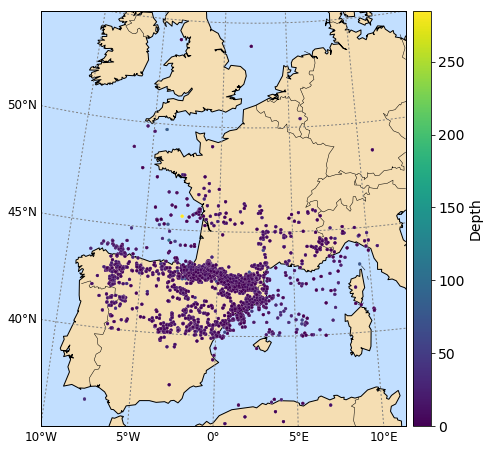

In [10]:
selector = cqt.CatalogueSelector(db1)
madrid_catalogue = selector.limit_to_agency("MDD")
cqt.plot_catalogue_map(map_config, madrid_catalogue)

Choose a particular sub-region of the catalogue ... then show it

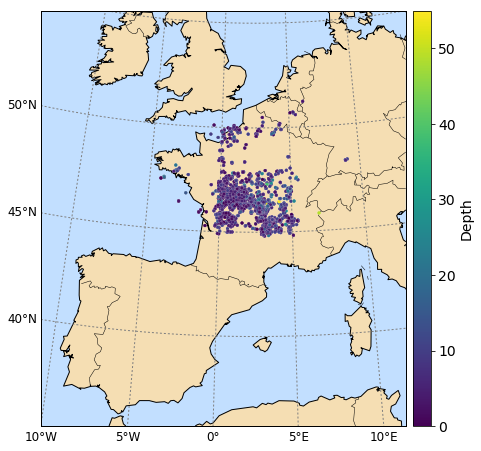

In [11]:
selector = cqt.CatalogueSelector(db1)
central_france = selector.select_within_bounding_box([0., 45., 5., 50.])
cqt.plot_catalogue_map(map_config, central_france)

## Exploring the catalogue

We could begin to execute queries on the catalogue based on what we are hoping should be there.

But to help us understand which queries might be more likely to return significant results it can be useful to know how many events are reported by particular agencies and in which magnitude scales.

There is a tool for this:

In [12]:
agency_magnitude_stats = cqt.get_agency_magtype_statistics(db1)

Agency: LDG - 42769 Origins
Ml (24265) | Md (20023) | mL (18324) | ML (14955) | MD (417) | ms (147) | md (108) | Ms (15) | Mb (15) | UK (6)
Agency: ISC - 35601 Origins
mb (963) | MS (225)
Agency: NEIC - 32202 Origins
mb (609) | MSZ (30) | UK (24) | MW (21) | ML (18) | MS (6) | MD (3)
Agency: STR - 18619 Origins
Ml (13707) | ML (11385) | MLv (2425) | mL (1647) | M (1149) | md (195) | mb (165) | UK (135) | mB (45) | Mwp (6) | Mw(mB (6) | MD (3)
Agency: CSEM - 17745 Origins
ML (10884) | mb (522) | ml (354) | MD (168) | Mw (48) | Ms (45) | MW (3)
Agency: MDD - 13434 Origins
mbLg (7758) | UK (3975) | MN (3501) | mb (3126) | ML (381) | MG (18) | mL (12) | MW (3) | Mb (3)
Agency: ROM - 10324 Origins
md (4320) | Ml (3033) | MD (2529) | Md (2439) | ML (2349) | mL (660) | UK (222) | mb (51) | M (25) | MW (18) | MLV (3)
Agency: ZUR - 6748 Origins
ML (4827) | mL (2586) | MLh (208) | Ml (21) | mb (18) | UK (12) | Ms (9) | MS (3)
Agency: GEN - 3750 Origins
ML (7080) | Ml (609)
Agency: ISCJB - 3477 O

Some notes:

* `LDG` - Laboratoire de Détection et de Géophysique/CEA

* `STR` - is Institut de Physique du Globe (France)

* `CSEM` - Euro-Mediterranean Seismological Centre (EMSC-CSEM)

* `MDD` - Instituto Geográfico Nacional (Madrid, Spain)

* `ROM` - INGV, Italy

* `ZUR` - Swiss Seismological Service (SED, ETH Zurich)

* `GEN` - Dipartimento per lo Studio del Territorio e delle sue Risorse (RSNI)

* `BGR` - BRGM, Orleans France


### Executing Queries

To find all of the events with magnitudes reported by specific pairs of agencies we can simply execute the function below.

In this example we ask to find all of the events with a reported local magnitude $M_L$ from the LDG network, and a reported body-wave magnitude $m_b$ from the ISC network.

Agency-Pairs: (LDG, ML) & (ISC, mb) returned 747 events


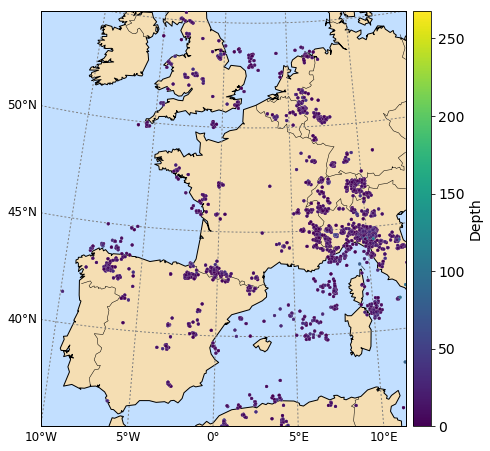

In [13]:
ldg_ml_isc_mb, query1_cat = cqt.get_agency_magnitude_pairs(db1, ("LDG", "ML"), ("ISC", "mb"), no_case=True)
cqt.plot_catalogue_map(map_config, query1_cat)

To visualise the comparisons we can either plot a conventional scatter plot or a density plot

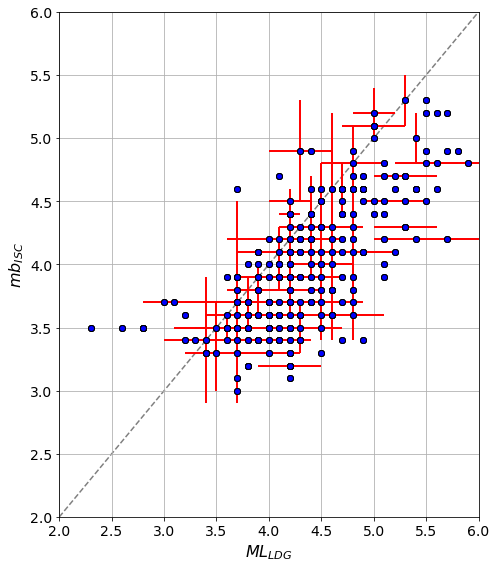

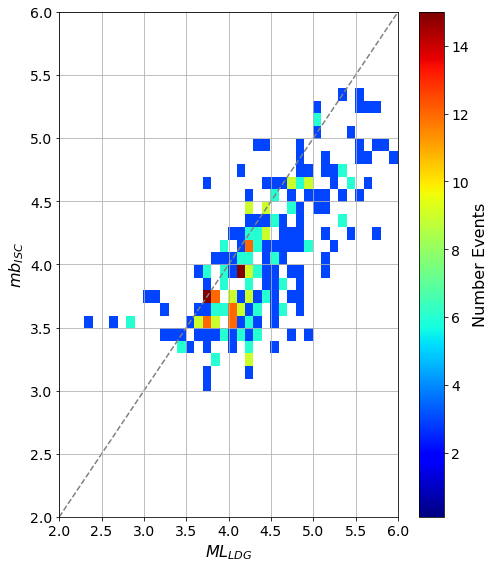

In [14]:
_ = cqt.plot_agency_magnitude_pair(ldg_ml_isc_mb)
_ = cqt.plot_agency_magnitude_density(ldg_ml_isc_mb, lognorm=False)

### Let's take a look at local magnitude scales

#### Comparing LDG and ROM

Agency-Pairs: (LDG, ML) & (ROM, ML) returned 5622 events


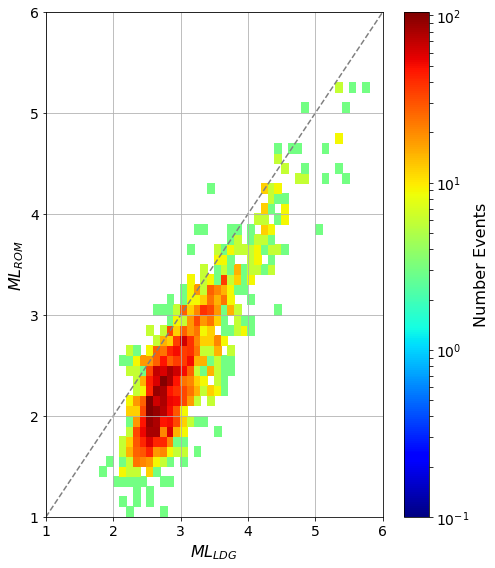

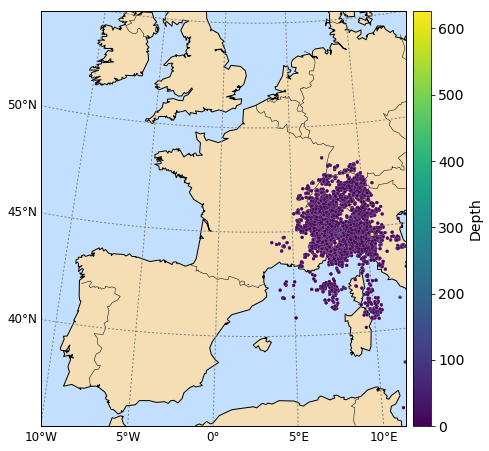

In [15]:
# Query the catalogue
ldg_ml_rom_ml, query3_cat = cqt.get_agency_magnitude_pairs(db1, ("LDG", "ML"), ("ROM", "ML"), no_case=True)
# Plot the density of event pairs
_ = cqt.plot_agency_magnitude_density(ldg_ml_rom_ml)
# Map the pairs
cqt.plot_catalogue_map(map_config, query3_cat)

#### Comparing LDG and SED

Agency-Pairs: (LDG, ML) & (ZUR_RMT, Mw) returned 240 events


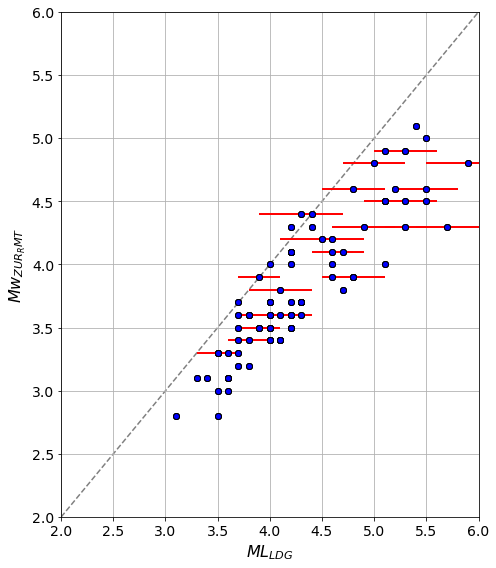

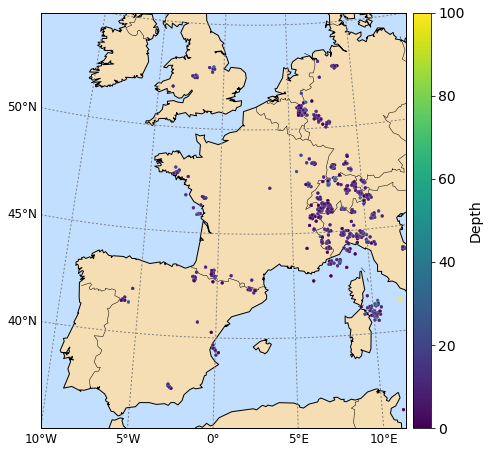

In [16]:
ldg_ml_zur_rmt, query4_cat = cqt.get_agency_magnitude_pairs(db1, ("LDG", "ML"), ("ZUR_RMT", "Mw"), no_case=True)
cqt.plot_agency_magnitude_pair(ldg_ml_zur_rmt)
cqt.plot_catalogue_map(map_config, query4_cat)

### Exploring the Relationships between Magnitude Scales

Large databases of earthquake can provide an enormous quantity of information to help understand how different recording agencies and different magnitude scales compare.

Ultimately, however, we are interested in deriving clear and applicable empirical models that can be used to convert between scales.

For this purpose, a set of regession tools are built in. As both magnitude scales are commonly reported with uncertainty, we make use of Python's tools for <b>Orthogonal Distance Regression</b>

Orthogonal Distance Regression is a more generalised form of orthogonal regression that searches for an optimal fit of a functional form (of any shape - not just linear!) taking into account error in both variables.

Several different functional forms are coded into the toolkit and can be called by a keyword (plus initial estimate of parameters)

* `polynomial`  - Nth order polynomial of the form: $y = c_0 + c_1 \cdot x + c_2 \cdot x^2 + \ldots c_n \cdot x^n$

* `2segmentM#.#` - 2-segment linear model with a cross-over at magnitude #.#, i.e. 

$y = c_0 + c_1 \cdot x$  (for $x < M_C$),    $y = c_2 + c_3 \cdot x$ for ($x \geq M_C$) 

* `exponential` - Exponential model of the form: $y = e^{\left( {c_0 + c_1 \cdot x} \right)} + c_2$

* `piecewise` - N-segment linear model with cross-over magnitudes determined in the fitting process

Beta: [-0.07804429  0.91199933]
Beta Std Error: [ 0.12640252  0.0299224 ]
Beta Covariance: [[ 0.0056288  -0.00132115]
 [-0.00132115  0.00031543]]
Residual Variance: 2.83854375999
Inverse Condition #: 0.0030167950985
Reason(s) for Halting:
  Sum of squares convergence


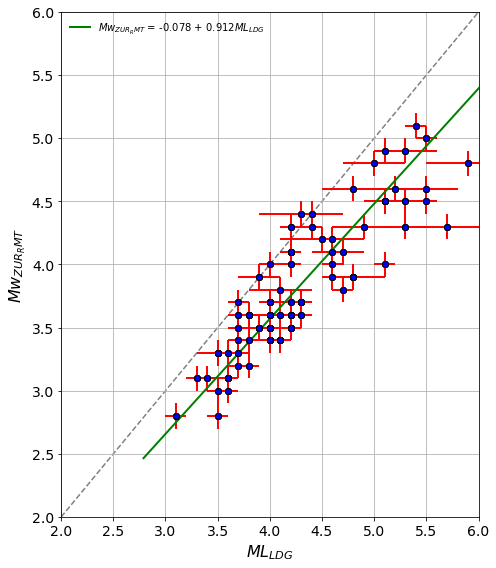

Model standard deviation is 0.270984478372


In [17]:
regressor1 = cqt.CatalogueRegressor(ldg_ml_zur_rmt)
results = regressor1.run_regression("polynomial", [0., 1.0])
regressor1.results.pprint()
regressor1.plot_model(overlay=False)
print "Model standard deviation is %s" % str(regressor1.standard_deviation)

Beta: [ 0.9977342   0.83215252 -0.40783322]
Beta Std Error: [ 0.06389012  0.05489078  0.25292699]
Beta Covariance: [[ 0.00144338 -0.00062191 -0.00569785]
 [-0.00062191  0.0010654   0.00229872]
 [-0.00569785  0.00229872  0.02262055]]
Residual Variance: 2.82805067026
Inverse Condition #: 0.0136032387586
Reason(s) for Halting:
  Sum of squares convergence


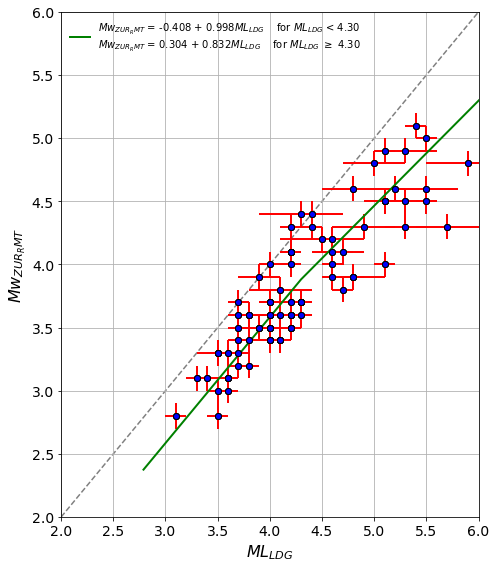

[0.21442063854425136, 0.30589140013418847]


In [18]:
regressor1 = cqt.CatalogueRegressor(ldg_ml_zur_rmt)
results = regressor1.run_regression("2segmentM4.3", [1.0, 1.0, 1.0])
regressor1.results.pprint()
regressor1.plot_model(overlay=False)
print regressor1.standard_deviation

Beta: [ 1.95445221  0.08798189 -6.47440877]
Beta Std Error: [  1.5252935    0.09698307  11.40942058]
Beta Covariance: [[  8.11128154e-01  -5.15617844e-02  -6.06716058e+00]
 [ -5.15617844e-02   3.27924985e-03   3.85610104e-01]
 [ -6.06716058e+00   3.85610104e-01   4.53847362e+01]]
Residual Variance: 2.86825238531
Inverse Condition #: 2.90673050147e-05
Reason(s) for Halting:
  Iteration limit reached


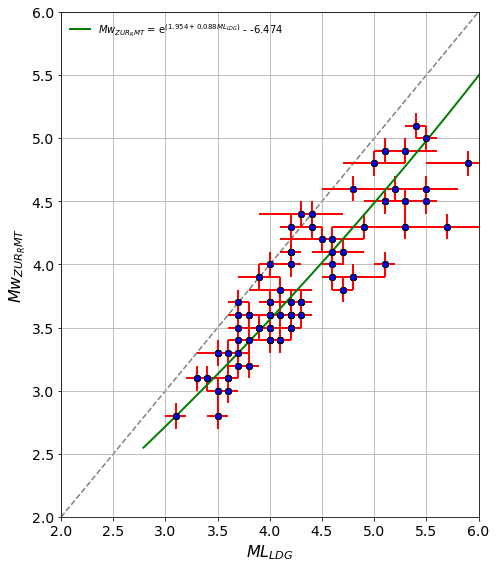

0.277664238818


In [19]:
regressor1b = cqt.CatalogueRegressor(ldg_ml_zur_rmt)
results = regressor1b.run_regression("exponential", [1.0, 1.0, 1.0])
regressor1b.results.pprint()
regressor1b.plot_model(overlay=False)
print regressor1b.standard_deviation

Agency-Pairs: (LDG, ML) & (CSEM, ML) returned 10284 events
Beta: [-0.0677478  1.0202841]
Beta Std Error: [ 0.00922252  0.00323576]
Beta Covariance: [[  3.58471054e-04  -1.23798970e-04]
 [ -1.23798970e-04   4.41274012e-05]]
Residual Variance: 0.237271037646
Inverse Condition #: 0.00601798563936
Reason(s) for Halting:
  Sum of squares convergence


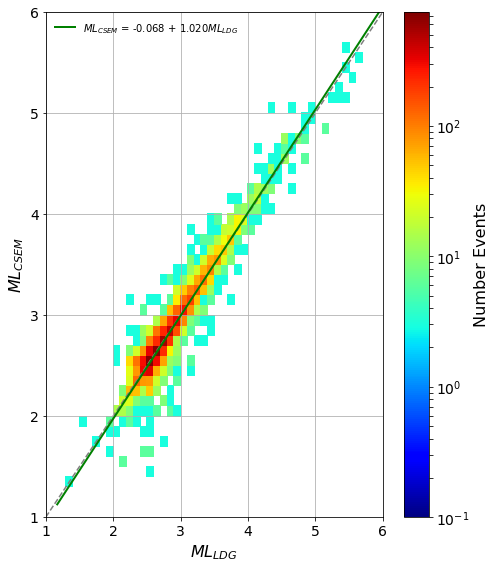

0.142526992874


In [20]:
ldg_ml_csem_ml, query3_cat = cqt.get_agency_magnitude_pairs(db1, ("LDG", "ML"), ("CSEM", "ML"), no_case=True)
regressor2 = cqt.CatalogueRegressor(ldg_ml_csem_ml)
results = regressor2.run_regression("polynomial", [0.0, 1.0])
regressor2.results.pprint()
regressor2.plot_model_density(overlay=False, sample=0)
print regressor2.standard_deviation

Agency-Pairs: (LDG, ML) & (STR, ML) returned 25113 events
Beta: [-0.0677478  1.0202841]
Beta Std Error: [ 0.00922252  0.00323576]
Beta Covariance: [[  3.58471054e-04  -1.23798970e-04]
 [ -1.23798970e-04   4.41274012e-05]]
Residual Variance: 0.237271037646
Inverse Condition #: 0.00601798563936
Reason(s) for Halting:
  Sum of squares convergence


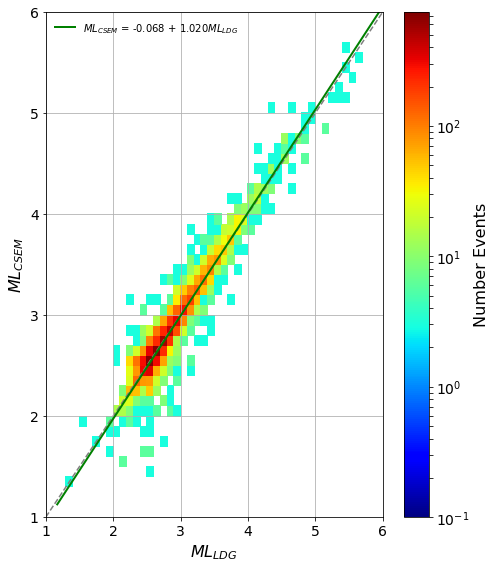

0.142526992874


In [21]:
ldg_ml_str_ml, query4_cat = cqt.get_agency_magnitude_pairs(db1, ("LDG", "ML"), ("STR", "ML"), no_case=True)
regressor2 = cqt.CatalogueRegressor(ldg_ml_csem_ml)
results = regressor2.run_regression("polynomial", [0.0, 1.0])
regressor2.results.pprint()
regressor2.plot_model_density(overlay=False, sample=0)
print regressor2.standard_deviation

Agency-Pairs: (STR, ML) & (ZUR_RMT, Mw) returned 237 events
Beta: [ 0.22245582  0.88482755]
Beta Std Error: [ 0.10142494  0.02462975]
Beta Covariance: [[ 0.00359605 -0.00086407]
 [-0.00086407  0.00021206]]
Residual Variance: 2.86064018224
Inverse Condition #: 0.00344162672994
Reason(s) for Halting:
  Sum of squares convergence


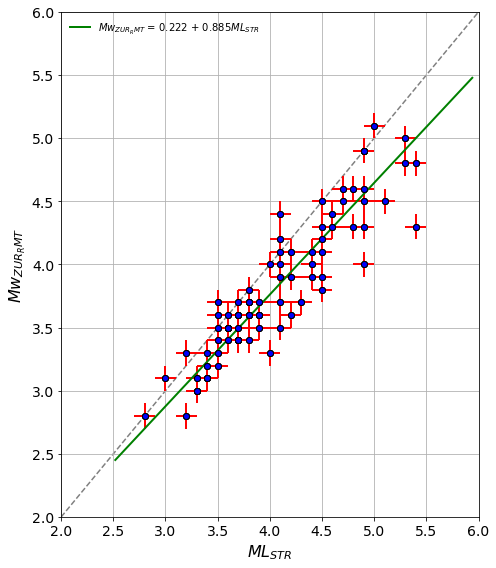

0.224883337454


In [22]:
str_ml_zur_mw, query4_cat = cqt.get_agency_magnitude_pairs(db1, ("STR", "ML"), ("ZUR_RMT", "Mw"), no_case=True)
regressor4 = cqt.CatalogueRegressor(str_ml_zur_mw)
results = regressor4.run_regression("polynomial", [0.0, 1.0])
regressor4.results.pprint()
regressor4.plot_model(overlay=False)
print regressor4.standard_deviation

Agency-Pairs: (ZUR_RMT, Mw) & (MED_RCMT, Mw) returned 66 events
Beta: [ 0.78410647  0.82355569]
Beta Std Error: [ 0.23452225  0.05204028]
Beta Covariance: [[ 0.05169278 -0.01144234]
 [-0.01144234  0.00254531]]
Residual Variance: 1.06399153721
Inverse Condition #: 0.00152492184001
Reason(s) for Halting:
  Sum of squares convergence


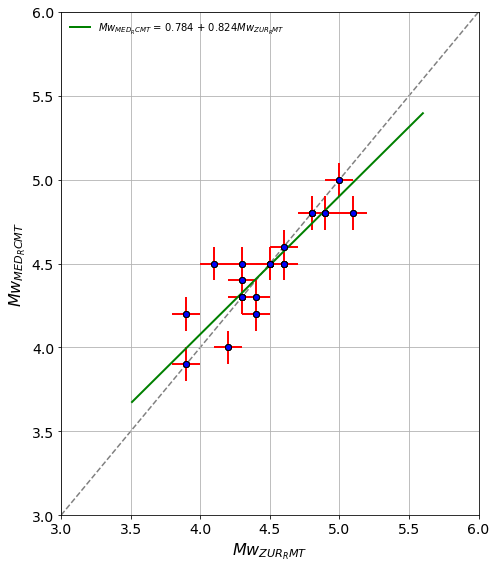

0.131587505881


In [23]:
zur_mw_med_mw, query4_cat = cqt.get_agency_magnitude_pairs(db1, ("ZUR_RMT", "Mw"), ("MED_RCMT", "Mw"), no_case=True)
regressor4 = cqt.CatalogueRegressor(zur_mw_med_mw)
results = regressor4.run_regression("polynomial", [0.0, 1.0])
regressor4.results.pprint()
regressor4.plot_model(overlay=False)
print regressor4.standard_deviation

## Catalogue Homogenisation

The homogenisation process applies a set of conversion formulae to convert from each individual scale found in the database into a target magnitude scale defined by the user.

The user may wish to use the models from the regressions - or specify their own

The user must supply the hierarchy (in terms of the location and magnitude) by which certain conversion models may be applied. The tool will apply the conversion rule in order of preference.

The hierarchies may be changed for different time periods, different depths or different ``keys`` (the key in this case may correspond to a particular geographical region)



### Defining the Hierarchies

In the current example we build a catalogue by harmonising data from four agencies

<b>Agencies</b>:

For the period 1900 to 1990: LDG, STR, ISC, ROM, MDD, NEIC
For the period 1900 to 2014: STR, LDG, ROM, ISC, NEIC, MDD

<b>Magnitudes (harmonising to Moment Magnitude)</b>:

For the period 1900 to 1976: GCMT, HRVD, ZUR_RMT, MED_RCMT, STR (ML), LDG (ML), ISC (Ms), (ISC mb)

In [24]:
from eqcat.isc_homogenisor import MagnitudeConversionRule, DynamicHomogenisor, HomogenisorPreprocessor

In [25]:
origin_rules = [
    ("1900/01/01 - 1989/12/31", ["LDG", "STR", "ISC", "ROM", "MDD", "NEIC"]),
    ("1990/01/01 - 2014/12/31", ["STR", "LDG", "ROM", "ISC", "NEIC", "MDD"])
]

Each magnitude conversion rule is input as a Python function

In [26]:
# Magnitude rules
def gcmt_hrvd(magnitude):
    return magnitude

def gcmt_hrvd_sigma(magnitude):
    return 0.0

def zur_med_rcmt(magnitude):
    return magnitude

def zur_med_rcmt_sigma(magnitude):
    """
    Adds uncertainty
    """
    return 0.1

def str_ml(magnitude):
    """
    From regression
    """
    return 0.320 + 0.858 * magnitude

def str_ml_sigma(magnitude):
    """
    From regression
    """
    return 0.21

def ldg_ml(magnitude):
    """
    Convert from LDG ML to Zurich CMT
    From regression 2 - segment
    """
    if magnitude < 4.3:
        return -0.397 + 0.995 * magnitude
    else:
        return 0.594 + 0.765 * magnitude

def ldg_ml_sigma(magnitude):
    """
    """
    if magnitude < 4.3:
        return 0.214
    else:
        return 0.284

def isc_ms(magnitude):
    """
    From Scordilis (2006)
    """
    if magnitude < 6.1:
        return 0.67 * magnitude + 2.07
    else:
        return 0.99 * magnitude + 0.08

def isc_ms_sigma(magnitude):
    """
    From Scordilis 2006
    """
    if magnitude < 6.1:
        return 0.17
    else:
        return 0.2

def isc_mb(magnitude):
    """
    From Scordilis (2006)
    """
    return 0.85 * magnitude + 1.03

def isc_mb_sigma(magnitude):
    """
    From Scordilis 2006
    """
    return 0.29    

To build the rules themselves, however, we use a class called ``MagnitudeConversionRule``, which stores information about the rule, i.e. to which agency it should be applied, to which magnitude scale, how to propagate uncertainty etc.

In [27]:
magnitude_rule_set = [
    MagnitudeConversionRule("GCMT", "Mw", gcmt_hrvd, gcmt_hrvd_sigma),
    MagnitudeConversionRule("HRVD", "Mw", gcmt_hrvd, gcmt_hrvd_sigma),
    MagnitudeConversionRule("ZUR_RMT", "Mw", zur_med_rcmt, zur_med_rcmt_sigma),
    MagnitudeConversionRule("MED_RCMT", "Mw", zur_med_rcmt, zur_med_rcmt_sigma),
    MagnitudeConversionRule("STR", "ML", str_ml, str_ml_sigma),
    MagnitudeConversionRule("LDG", "ML", ldg_ml, ldg_ml_sigma),
    MagnitudeConversionRule("ISC", "Ms", isc_ms, isc_ms_sigma),
    MagnitudeConversionRule("ISC", "mb", isc_mb, isc_mb_sigma)
]

magnitude_rules = [
    ("1900/01/01 - 2015/12/31", magnitude_rule_set)
]

### Homogenise the Catalogue

As a pre-processing step we apply a tool that can search through the database and see which, if any, rule can be
applied to each earthquake

Those earthquakes for which no selection rule can be applied are neglected in the homogenisation process.


In this case we are expecting that the hierarchies changes with time - so we tell the preprocessing tool that the rules are time dependent.

In [28]:
preprocessor = HomogenisorPreprocessor(rule_type="time")
preprocessed_catalogue = preprocessor.execute(catalogue, origin_rules, magnitude_rules)

##### Run the Homogenisation Tool ...

The logging can be useful to understand which rule (and which hierarchy) was adopted for each event. Most of the time it is not necessary, but if you find strange results in the harmonised catalogue then it is helpful to check.

In [29]:
homogenisor = DynamicHomogenisor(preprocessed_catalogue, logging=True)

In [30]:
output_catalogue = homogenisor.homogenise(magnitude_rules, origin_rules)

906812 -- None --  None
904164 -- None --  None
894347 -- None --  None
881720 ISC-Ms ISC|ISC-Ms
874864 -- None --  None
872748 ISC-Ms ISC|ISC-Ms
872966 -- None --  None
870668 -- None --  None
869446 ISC-mb ISC|ISC-mb
869498 ISC-mb ISC|ISC-mb
869555 ISC-mb ISC|ISC-mb
869020 -- None --  None
866405 ISC-mb ISC|ISC-mb
865533 ISC-mb ISC|ISC-mb
860812 ISC-mb ISC|ISC-mb
858899 -- None --  None
859067 -- None --  None
857741 ISC-mb ISC|ISC-mb
857134 -- None --  None
856497 ISC-mb ISC|ISC-mb
853779 ISC-mb ISC|ISC-mb
853964 ISC-mb ISC|ISC-mb
853355 ISC-mb ISC|ISC-mb
851761 ISC-mb ISC|ISC-mb
851873 ISC-mb ISC|ISC-mb
850909 ISC-mb ISC|ISC-mb
848187 ISC-mb ISC|ISC-mb
847606 ISC-mb ISC|ISC-mb
846876 -- None --  None
845737 ISC-mb ISC|ISC-mb
840767 ISC-mb ISC|ISC-mb
838189 ISC-mb ISC|ISC-mb
838315 ISC-mb ISC|ISC-mb
836645 ISC-mb ISC|ISC-mb
833386 ISC-mb ISC|ISC-mb
832236 ISC-mb ISC|ISC-mb
832527 -- None --  None
831630 ISC-mb ISC|ISC-mb
830122 ISC-mb ISC|ISC-mb
824939 -- None --  None
824073 ISC-mb

If we wish, we can export the log to a csv file

In [31]:
homogenisor.dump_log("output_data/homogenisation1_logfile.csv")

### Finally ... we export the homogenised catalogue

In [32]:
homogenisor.export_homogenised_to_csv("output_data/output_catalogue.csv")